In [206]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


In [207]:
torch.__version__

'2.1.2+cpu'

In [208]:
torchtext.__version__

'0.16.2+cpu'

# Task1: Get Language Pair

scb_mt_enth_2020 is the en-th text dataset from siam commercial bank (SCB) that has 1 milions pairs of text. the text is from various sources including news, Wikipedia articles, SMS messages, task-based dialogs, web-crawled data and government documents.

Since my notebook cannot use GPU, I decided to use only 10,000 pairs of text on test dataset of the dataset

In [209]:
from datasets import load_dataset

dataset = load_dataset("scb_mt_enth_2020", "enth",split="test")

In [210]:
dataset

Dataset({
    features: ['translation', 'subdataset'],
    num_rows: 100177
})

In [211]:
# split train, test, and validation dataset
from sklearn.model_selection import train_test_split

selected_data, remaining_data = train_test_split(dataset['translation'], test_size=0.9, random_state=999)
train_data, test_data = train_test_split(selected_data, test_size=0.1, random_state=999)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=999)

In [212]:
# the number of pair text on training data
len(train_data)

7212

In [246]:
# show the sample data to see the data architecture
train_data[0]

{'en': "This holster will only belt up to your belly button, so won't hold anything thicker than an iPhone while working out.",
 'th': 'สายคาดนี้รัดได้ถึงสะดือเท่านั้น แบกอะไรที่ใหญ่กว่าไอโฟนระหว่างออกกําลังกายไม่ได้'}

## Preprocessing

### Tokenizing

In [214]:
# create dictionary for keeping tokenizer function and vocab list of Thai and English
token_transform = {}
vocab_transform = {}

In [215]:
from torchtext.data.utils import get_tokenizer
import pythainlp
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'th'

# create function to tokenize the text to word/token
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = lambda x: list(pythainlp.tokenize.word_tokenize(x, engine="newmm"))

In [247]:
# print the sample English text along with the tokenization list 
print("Sentence: ", train_data[0]['en'])
print("Tokenization: ", token_transform[SRC_LANGUAGE](train_data[0]['en']))

Sentence:  This holster will only belt up to your belly button, so won't hold anything thicker than an iPhone while working out.
Tokenization:  ['This', 'holster', 'will', 'only', 'belt', 'up', 'to', 'your', 'belly', 'button', ',', 'so', 'wo', "n't", 'hold', 'anything', 'thicker', 'than', 'an', 'iPhone', 'while', 'working', 'out', '.']


In [217]:
# print the sample Thai text along with the tokenization list 
print("Sentence: ", train_data[1]['th'])
print("Tokenization: ", token_transform[TRG_LANGUAGE](train_data[1]['th']))

Sentence:  โอ้ ขอโทษด้วยค่ะ เหมือนกับทางร้านจะไม่มีเก้าอี้สูงให้บริการนะคะ
Tokenization:  ['โอ้', ' ', 'ขอโทษ', 'ด้วย', 'ค่ะ', ' ', 'เหมือนกับ', 'ทาง', 'ร้าน', 'จะ', 'ไม่', 'มี', 'เก้าอี้', 'สูง', 'ให้บริการ', 'นะคะ']


In [218]:
#  function to list of tokens of all data
def yield_tokens(data, language):

    for data_sample in data:
        yield token_transform[language](data_sample[language]) #either first or second index

In [219]:
# define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

## Numericalization

In [220]:
from torchtext.vocab import build_vocab_from_iterator

# create vocabs list in both of English and Thai and keep it on vocab_transform dictionary
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_data, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates the symbols at first                                       

# set UNK_IDX as the default index. if tokens is not on train data vocabs, it will return <unk>
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [222]:
import pickle
# Save token_transform dictionary for using in web app
with open('vocab_transform.pkl', 'wb') as f:
    pickle.dump(vocab_transform, f)

In [ ]:
# test the vocab_transform with some sample
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[282, 18, 11, 0, 11]

In [ ]:
# create mapping for call the word back from interger
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

# test with some number
mapping[1891]

'beauty'

In [ ]:
# first index need to be <unk>
mapping[0]

'<unk>'

In [ ]:
# check the special symbol index
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [ ]:
#check unique vocabularies
len(mapping)

10015

## Preparing the dataloader

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for example in batch:
        src_sample = example['en']
        trg_sample = example['th']
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [ ]:
# create DataLoader on train, test, and validation
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val_data,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [ ]:
for en, _, th in train_loader:
    break

In [ ]:
# print the train dataloader shape in both Thai and English
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Thai shape: ", th.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 128])
Thai shape:  torch.Size([64, 277])


# Task2: Experiment with Attention Mechanisms

## Model

### Encoder Layer

In [ ]:
# create class for build 1 encoder layer
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attention_type): #pf_dim = feed forward dim
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim) # make number to smaller
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, attention_type)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

### Encoder

In [ ]:
# create class for build many encoder layers
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, attention_type, max_length = 700):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device,attention_type)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos)) # *scale to scale down
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src
            

### Mutli Head Attention Layer

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, attention_type):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        self.attention_type = attention_type
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        self.v        = nn.Linear(self.head_dim, 1, bias = False)
        self.W        = nn.Linear(self.head_dim, self.head_dim) #for decoder input_
        self.U        = nn.Linear(self.head_dim, self.head_dim)  #for encoder_outputs
        self.W_mal    = nn.Linear(self.head_dim, self.head_dim) # for encoder on multiplicative attention
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim) #for output
        
        self.dropout  = nn.Dropout(dropout)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        src_len = key.shape[1]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]
        
        #separate in many version
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        #Q = [batch_size, n heads, query len, head_dim]
        if self.attention_type == "general":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) #[batch_size, n heads, query len, key len]
        elif self.attention_type == "multiplicative":
            energy = torch.matmul(Q,(self.W_mal(K)).permute(0, 1, 3, 2)) #[batch_size, n heads, query len, key len]

        elif self.attention_type == "additive":

            energy = self.v(torch.tanh(self.U(K) + self.W(Q))) #[batch_size, n heads, query len, 1]
                   
             # Ensure the energy tensor has the same shape as in other attention mechanisms
            energy = energy.expand(-1, -1, -1,src_len)  #[batch_size, n heads, query len, key len]
                
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

### Position-wise Feedforward Layer

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Decoder Layer

In [ ]:
# create the class for build 1 decoder layer
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attention_type):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, attention_type)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, attention_type)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg)) #trg_mask to make sure it does not attention future token
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

### Decoder

In [ ]:
# create the class for build many decoder layers
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device, attention_type,max_length = 700):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device,attention_type)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

In [ ]:
# combine all model
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## 6. Training

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
# function for calculate the total parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(f'______\n{sum(params):>6}')

In [ ]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
               
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [ ]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [ ]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [ ]:
# function for calculate the time consuming in 1 epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

### Model with general attention

In [ ]:
enc_general = Encoder(input_dim, 
              hid_dim, 
              enc_layers, 
              enc_heads, 
              enc_pf_dim, 
              enc_dropout, 
              device,'general')

dec_general = Decoder(output_dim, 
              hid_dim, 
              dec_layers, 
              dec_heads, 
              dec_pf_dim, 
              enc_dropout, 
              device, 'general')

model_general = Seq2SeqTransformer(enc_general, dec_general, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_general.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(10015, 256)
    (pos_embedding): Embedding(700, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (v): Linear(in_features=32, out_features=1, bias=False)
          (W): Linear(in_features=32, out_features=32, bias=True)
          (U): Linear(in_features=32, out_features=32, bias=True)
          (W_mal): Linear(in_features=32, out_features=32, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False

In [ ]:
count_parameters(model_general)

______
11282133


In [ ]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer_general = optim.Adam(model_general.parameters(), lr=lr)
criterion_general = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [ ]:
# training for general attention

best_valid_loss_general = float('inf')
num_epochs = 5
clip       = 1

save_path_general = 'Seq2SeqTransformer_with_general.pt'

train_losses_general = []
valid_losses_general = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss_general = train(model_general, train_loader, optimizer_general, criterion_general, clip, train_loader_length)
    valid_loss_general = evaluate(model_general, valid_loader, criterion_general, val_loader_length)
    
    # for plotting in next task
    train_losses_general.append(train_loss_general)
    valid_losses_general.append(valid_loss_general)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the model if the new validation loss is lower than previous one
    if valid_loss_general < best_valid_loss_general:
        best_valid_loss_general = valid_loss_general
        torch.save(model_general.state_dict(), save_path_general) 
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_general:.3f} | Train PPL: {math.exp(train_loss_general):7.3f}')
    print(f'\t Val. Loss: {valid_loss_general:.3f} |  Val. PPL: {math.exp(valid_loss_general):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 19m 8s
	Train Loss: 6.541 | Train PPL: 692.646
	 Val. Loss: 5.870 |  Val. PPL: 354.287
Epoch: 02 | Time: 20m 34s
	Train Loss: 5.832 | Train PPL: 340.993
	 Val. Loss: 5.479 |  Val. PPL: 239.671
Epoch: 03 | Time: 20m 42s
	Train Loss: 5.458 | Train PPL: 234.711
	 Val. Loss: 5.165 |  Val. PPL: 174.984
Epoch: 04 | Time: 32m 17s
	Train Loss: 5.078 | Train PPL: 160.459
	 Val. Loss: 4.869 |  Val. PPL: 130.210
Epoch: 05 | Time: 21m 2s
	Train Loss: 4.763 | Train PPL: 117.108
	 Val. Loss: 4.683 |  Val. PPL: 108.132


### Model with multiplicative attention

In [ ]:
enc_multi = Encoder(input_dim, 
              hid_dim, 
              enc_layers, 
              enc_heads, 
              enc_pf_dim, 
              enc_dropout, 
              device,'multiplicative')

dec_multi = Decoder(output_dim, 
              hid_dim, 
              dec_layers, 
              dec_heads, 
              dec_pf_dim, 
              enc_dropout, 
              device, 'multiplicative')

model_multi = Seq2SeqTransformer(enc_multi, dec_multi, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_multi.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(10015, 256)
    (pos_embedding): Embedding(700, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (v): Linear(in_features=32, out_features=1, bias=False)
          (W): Linear(in_features=32, out_features=32, bias=True)
          (U): Linear(in_features=32, out_features=32, bias=True)
          (W_mal): Linear(in_features=32, out_features=32, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False

In [ ]:
count_parameters(model_multi)

______
11282133


In [ ]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer_multi = optim.Adam(model_multi.parameters(), lr=lr)
criterion_multi = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [ ]:
# training for general attention

best_valid_loss_multi = float('inf')
num_epochs = 5
clip       = 1

save_path_multi = 'Seq2SeqTransformer_with_mulltiplicative.pt'

train_losses_multi = []
valid_losses_multi = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss_multi = train(model_multi, train_loader, optimizer_multi, criterion_multi, clip, train_loader_length)
    valid_loss_multi = evaluate(model_multi, valid_loader, criterion_multi, val_loader_length)
    
    #for plotting
    train_losses_multi.append(train_loss_multi)
    valid_losses_multi.append(valid_loss_multi)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the model if the new validation loss is lower than previous one
    if valid_loss_multi < best_valid_loss_multi:
        best_valid_loss_multi = valid_loss_multi
        torch.save(model_multi.state_dict(), save_path_multi)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_multi:.3f} | Train PPL: {math.exp(train_loss_multi):7.3f}')
    print(f'\t Val. Loss: {valid_loss_multi:.3f} |  Val. PPL: {math.exp(valid_loss_multi):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 29m 13s
	Train Loss: 6.576 | Train PPL: 717.776
	 Val. Loss: 5.971 |  Val. PPL: 392.049
Epoch: 02 | Time: 27m 0s
	Train Loss: 5.885 | Train PPL: 359.695
	 Val. Loss: 5.532 |  Val. PPL: 252.765
Epoch: 03 | Time: 24m 6s
	Train Loss: 5.521 | Train PPL: 249.855
	 Val. Loss: 5.265 |  Val. PPL: 193.481
Epoch: 04 | Time: 25m 24s
	Train Loss: 5.236 | Train PPL: 187.910
	 Val. Loss: 5.025 |  Val. PPL: 152.213
Epoch: 05 | Time: 24m 6s
	Train Loss: 4.944 | Train PPL: 140.339
	 Val. Loss: 4.812 |  Val. PPL: 122.959


### Model with additive attention (I tried to do it)

In [ ]:
enc_add = Encoder(input_dim, 
              hid_dim, 
              enc_layers, 
              enc_heads, 
              enc_pf_dim, 
              enc_dropout, 
              device,'additive')

dec_add = Decoder(output_dim, 
              hid_dim, 
              dec_layers, 
              dec_heads, 
              dec_pf_dim, 
              enc_dropout, 
              device, 'additive')

model_add = Seq2SeqTransformer(enc_add, dec_add, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_add.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(10015, 256)
    (pos_embedding): Embedding(700, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (v): Linear(in_features=32, out_features=1, bias=False)
          (W): Linear(in_features=32, out_features=32, bias=True)
          (U): Linear(in_features=32, out_features=32, bias=True)
          (W_mal): Linear(in_features=32, out_features=32, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False

In [ ]:
count_parameters(model_add)

______
11282133


In [ ]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer_add = optim.Adam(model_add.parameters(), lr=lr)
criterion_add = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [248]:
# training for additive attention

best_valid_loss_add = float('inf')
num_epochs = 5
clip       = 1

save_path_add = 'Seq2SeqTransformer_with_additive.pt'

train_losses_add = []
valid_losses_add = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss_add = train(model_add, train_loader, optimizer_add, criterion_add, clip, train_loader_length)
    valid_loss_add = evaluate(model_add, valid_loader, criterion_add, val_loader_length)
    
    #for plotting
    train_losses_add.append(train_loss_add)
    valid_losses_add.append(valid_loss_add)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the model if the new validation loss is lower than previous one
    if valid_loss_add < best_valid_loss_add:
        best_valid_loss_add = valid_loss_add
        torch.save(model_add.state_dict(), save_path_add)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_add:.3f} | Train PPL: {math.exp(train_loss_add):7.3f}')
    print(f'\t Val. Loss: {valid_loss_add:.3f} |  Val. PPL: {math.exp(valid_loss_add):7.3f}')
    
    #lower perplexity is better

| Attentions | Training Loss | Training PPL | Validation Loss | Validation PPL|
|:------------------------|:----------:|:----------:|:----------:|:----------:|
| General Attention  |       4.763      |    117.108     |  4.683 | 108.132 |  
| Multiplication Attention |   4.944    |    140.339   | 4.812 | 122.959 |  
| Additive Attention     |      -          |    -    |  -  |   -    |


# Task3

### Performance of each attention

In [ ]:
# load the saved model
loaded_model_general = Seq2SeqTransformer(enc_general, dec_general, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
loaded_model_multi = Seq2SeqTransformer(enc_multi, dec_multi, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
loaded_model_general.load_state_dict(torch.load('Seq2SeqTransformer_with_general.pt'))
loaded_model_multi.load_state_dict(torch.load('Seq2SeqTransformer_with_mulltiplicative.pt'))

<All keys matched successfully>

In [ ]:
# function for calculate the accuracy of model based on correction that model need to predict same with target
def model_accuracy(model, loader,loader_length):
    
    model.eval()
    count = 0
        
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
               
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            output = output.argmax(1)
            #output = [batch size * trg len - 1]
            #trg = [batch size * trg len - 1]                       

            if output.tolist() == trg.tolist():
                count+=1
            else:
                continue         
       
    return (count / loader_length)*100

In [ ]:
general_acc=model_accuracy(loaded_model_general,test_loader,test_loader_length)
general_acc

0.0

In [ ]:
multi_acc=model_accuracy(loaded_model_multi,test_loader,test_loader_length)
multi_acc

0.0

The accuracy of the models is low. it may cause from the less number of epochs and the dataset is not good enough. 

In [ ]:
# test genearal attentive model with test set
test_loss = evaluate(loaded_model_general, test_loader, criterion_general, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.619 | Test PPL: 101.424 |


In [ ]:
# test multiplicative attentive model with test set
test_loss = evaluate(loaded_model_multi, test_loader, criterion_multi, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.753 | Test PPL: 115.894 |


| Attentions | Translation Accuracy | Test Loss| Test PPL| training time in 5 epochs|  
|:------------------------|:----------:|:----------:|:----------:|:----------:|
| General Attention  |       0.0      |    4.619     |  101.424 | 113m 45.2s |  
| Multiplication Attention |   0.0    |    4.753  |  115.894 | 129m 50.4s |  
| Additive Attention     |      -          |    -    |  -  |   -    |

### Plot training and validation Loss

Text(0, 0.5, 'loss')

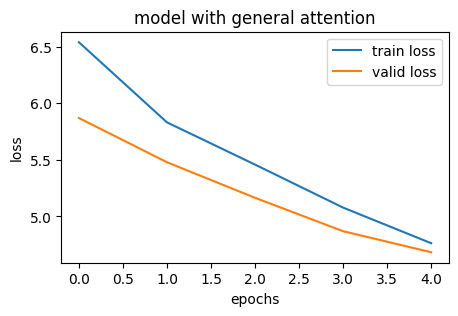

In [ ]:
# plot for model with general attention
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses_general, label = 'train loss')
ax.plot(valid_losses_general, label = 'valid loss')
plt.legend()
ax.set_title('model with general attention')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

Text(0, 0.5, 'loss')

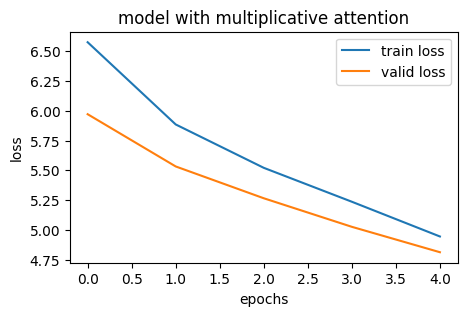

In [ ]:
# plot for model with multiplicative attention
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses_multi, label = 'train loss')
ax.plot(valid_losses_multi, label = 'valid loss')
plt.legend()
ax.set_title('model with multiplicative attention')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

From the graphs, the model can make lower loss if I train the models more 

### Attention maps

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm

# function for printing the attention maps
def display_attention(src_sentence, trg_sentence, model):

    src_text = text_transform[SRC_LANGUAGE](src_sentence).to(device)
    trg_text = text_transform[TRG_LANGUAGE](trg_sentence).to(device)

    src_text = src_text.reshape(1, -1)  #because batch_size is 1
    trg_text = trg_text.reshape(1, -1)

    text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

    model.eval()
    with torch.no_grad():
        output, attentions = model(src_text, trg_text)

    output = output.squeeze(0)

    output = output[1:]  #trg_len, trg_output_dim
    output_max = output.argmax(1) #returns max indices to take the top token with highest probabilities
    mapping = vocab_transform[TRG_LANGUAGE].get_itos()
    
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    attention = attentions[0, 0, :, :]
    src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](src_sentence) + ['<eos>']
    trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    # Load Thai font
    thai_font_path = 'TH Sarabun New Regular.ttf'  # Specify the path to your Thai font
    thai_font_prop = fm.FontProperties(fname=thai_font_path)
    
    y_ticks =  [''] + trg_tokens
    x_ticks =  [''] + src_tokens 
    
    if model == model_general:
        ax.set_title('model with general attention')
    elif model == model_multi:
        ax.set_title('model with multiplicative attention')
    ax.set_xticklabels(x_ticks, rotation=45)  # Set Thai font for x-axis
    ax.set_yticklabels(y_ticks, fontproperties=thai_font_prop)  # Set Thai font for y-axis

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
# sample the data from test data
sentence = test_data[20]['en']
translate = test_data[20]['th']

C:\Users\earth\AppData\Local\Temp\ipykernel_58884\914141737.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)  # Set Thai font for x-axis
C:\Users\earth\AppData\Local\Temp\ipykernel_58884\914141737.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks, fontproperties=thai_font_prop)  # Set Thai font for y-axis


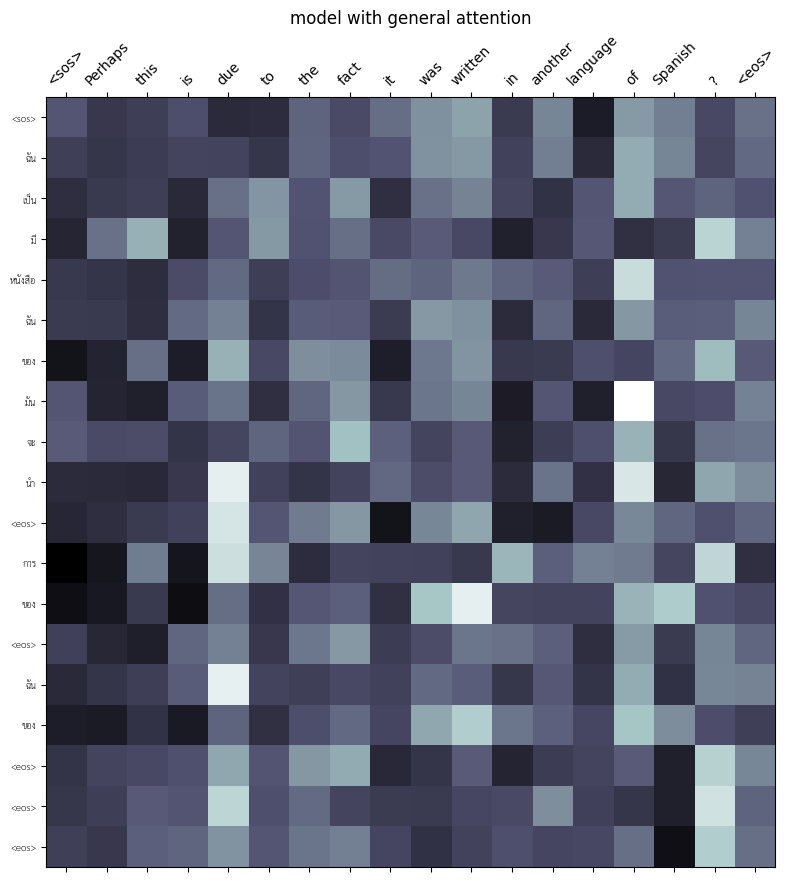

In [ ]:
# print the attention map of model with general attention
display_attention(sentence, translate, loaded_model_general)

C:\Users\earth\AppData\Local\Temp\ipykernel_58884\914141737.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)  # Set Thai font for x-axis
C:\Users\earth\AppData\Local\Temp\ipykernel_58884\914141737.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks, fontproperties=thai_font_prop)  # Set Thai font for y-axis


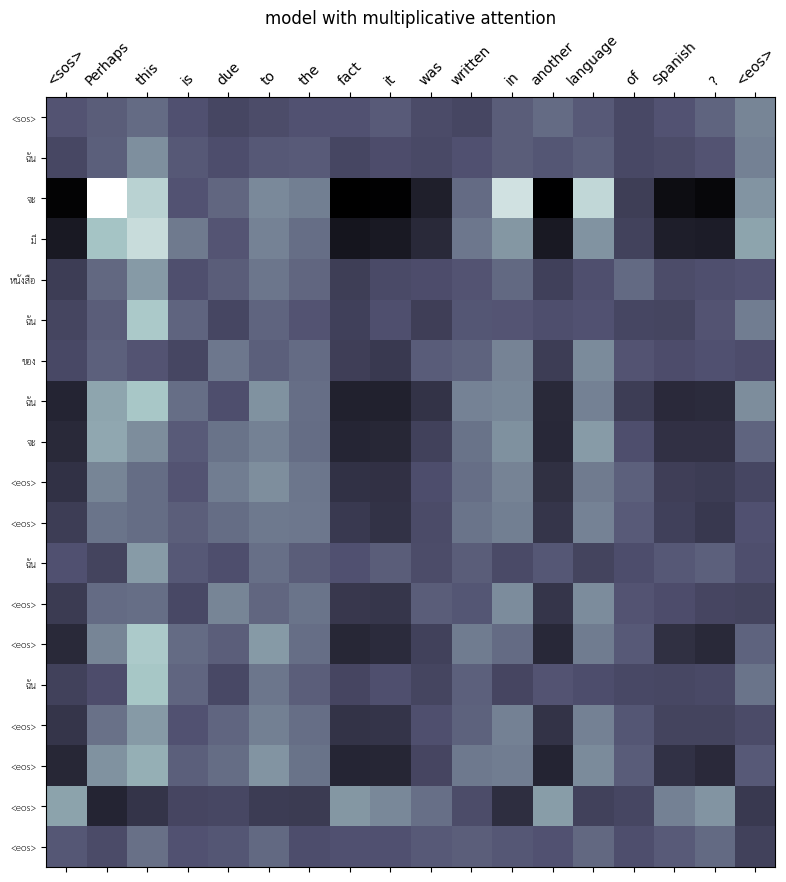

In [ ]:
# print the attention map of model with multiplicative attention
display_attention(sentence, translate, loaded_model_multi)

Based on training time, validation loss&PPL and test loss&PPL, I can conclude that model with general attention is better than model with multiplicative attention. Moreover, for attention maps, model with the general attention is slighly reasonable than model with the multiplicative attention

# Task4 Demo for web app

In [226]:
# load the saved vocab transform file
with open('vocab_transform.pkl', 'rb') as f:
        vocab_transform_load = pickle.load(f)


In [245]:
def translate_english_to_thai(model, english_sentence, device, SRC_LANGUAGE, TRG_LANGUAGE, SOS_IDX, EOS_IDX, token_transform, vocab_transform_load):
    # tokenize the input English sentence
    tokenized_sentence = token_transform[SRC_LANGUAGE](english_sentence)
    
    # convert tokens to interger (index) using the English vocabulary
    indexed_sentence = [vocab_transform[SRC_LANGUAGE][token] for token in tokenized_sentence]
    num = len(indexed_sentence)
    
    
    # convert interger (index) to tensor and add batch dimension
    input_tensor = torch.LongTensor(indexed_sentence).unsqueeze(0).to(device)
    
    trg_tokens = []
    trg_token = SOS_IDX
    
    # translate the English sentence to Thai
    with torch.no_grad():
        for _ in range(num):
            # convert list to tensor
            trg_tensor = torch.LongTensor([[trg_token]]).to(device)
            output, _ = model(input_tensor.reshape(1, -1), trg_tensor.reshape(1, -1))
            
            # get the most likely next token
            trg_token = torch.argmax(output, dim=2)[:,-1].item()
            
            # append the token to the list
            trg_tokens.append(trg_token)
            
    
    # convert indices to tokens and then to words
    translated_tokens = [vocab_transform[TRG_LANGUAGE].get_itos()[index] for index in trg_tokens]
    
    # concatenate tokens to form the translated sentence
    translated_sentence = ''.join(translated_tokens)
    
    return translated_sentence

# Example usage:
english_sentence = "you can"
translated_thai = translate_english_to_thai(loaded_model_general, english_sentence, device, SRC_LANGUAGE, TRG_LANGUAGE, SOS_IDX, EOS_IDX, token_transform, vocab_transform)
print("Translated Thai:", translated_thai)


Translated Thai: คุณสามารถ
